# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)


. [Correlations](#correlations)


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Dataset Overview

[Provide a high-level overview of the dataset. This should include the source of the dataset, the number of samples, the number of features, and example showing the structure of the dataset.]


In [2]:
### Biovolume_per_site_class_and_depth.pkl - Contains biovolume data for each Profile_id and depth, separated into log-spaced size classes
#       - Column names indicate size classes from 0.2 to ~10 mm equivalent spherical diameter (ESD)
#       - Biovolume in mm³ per liter seawater
#       - Profile_id is always a string
#       - depth in dbar (approximately equal to depth in meters) starts at 12.5 dbar and increases in 25 dbar steps to 987.5 dbar (40 depth levels)
#       - depth_bin = integer from 0 to 39, indicating the depth level (0 = 12.5 dbar, 1 = 37.5 dbar, ..., 39 = 987.5 dbar)

BV_data = pd.read_pickle("/Users/sacksen/Documents/ML_Tensorflow/data/Biovolume_per_size_class_and_depth.pkl")
#BV_data.info()
BV_data.head()


,Profile_id,depth,depth_bin,Biovolume [ppm] (ESD: 0.203-0.256 mm),Biovolume [ppm] (ESD: 0.256-0.323 mm),Biovolume [ppm] (ESD: 0.323-0.406 mm),Biovolume [ppm] (ESD: 0.406-0.512 mm),Biovolume [ppm] (ESD: 0.512-0.645 mm),Biovolume [ppm] (ESD: 0.645-0.813 mm),Biovolume [ppm] (ESD: 0.813-1.02 mm),Biovolume [ppm] (ESD: 1.02-1.29 mm),Biovolume [ppm] (ESD: 1.29-1.63 mm),Biovolume [ppm] (ESD: 1.63-2.05 mm),Biovolume [ppm] (ESD: 2.05-2.58 mm),Biovolume [ppm] (ESD: 2.58-3.25 mm),Biovolume [ppm] (ESD: 3.25-4.1 mm),Biovolume [ppm] (ESD: 4.1-5.16 mm),Biovolume [ppm] (ESD: 5.16-6.5 mm),Biovolume [ppm] (ESD: 6.5-8.19 mm),Biovolume [ppm] (ESD: 8.19-10.3 mm)
0,0000a_WMO5906623_recovery_profiles,12.5,0,0.114562,0.104158,0.078780,0.066139,0.081787,0.062770,0.122905,0.036882,0.019573,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0000a_WMO5906623_recovery_profiles,37.5,1,0.136750,0.117453,0.113992,0.117148,0.142345,0.118748,0.115595,0.203758,0.142237,0.047568,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0000a_WMO5906623_recovery_profiles,62.5,2,0.127222,0.118740,0.134736,0.156787,0.177491,0.146157,0.145280,0.131664,0.024792,0.000000,0.197754,0.0,0.0,0.0,0.0,0.0,0.0
3,0000a_WMO5906623_recovery_profiles,87.5,3,0.175240,0.167346,0.235771,0.252304,0.290185,0.307278,0.273936,0.196201,0.248322,0.143855,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0000a_WMO5906623_recovery_profiles,112.5,4,0.126923,0.157563,0.205987,0.263124,0.378548,0.511686,0.522228,0.528398,0.478425,0.595710,0.245062,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
### Environmental_data_depth_resolved.pkl - Contains metadata for every Profile_id and depth: 
#       - Latitude, Longitude & datetime (identical for all depths of one Profile_id)
#       - 10 environmental variables from CopernicusMarine Services, interpolated to the sampling locations, times and depths
#       - distance_to_coast_km (calculated from Latitude & Longitude)
#       - MarineRegion (categorical variable, from MarineRegions shapefile)

env_data = pd.read_pickle('/Users/sacksen/Documents/ML_Tensorflow/data/Environmental_data_depth_resolved.pkl')
#env_data.info()
# subset env_data to only contain Profile_ids present in BV_data
env_data_subset = env_data[env_data['Profile_id'].isin(BV_data['Profile_id'])]
#env_data_subset.info()
env_data_subset.head()
# save subsetted env_data for future use
#env_data_subset.to_pickle('/Users/sacksen/Documents/ML_Tensorflow/data/Environmental_data_depth_resolved_subset.pkl')

,Profile_id,Latitude,Longitude,datetime,depth,ph,chl,no3,po4,si,o2,fe,phyc,thetao_mean,so_mean,distance_to_coast_km,MarineRegion
0,s033,-75.271,-147.1265,2018-04-02 12:32:55,12.5,8.052681,0.286524,27.321437,1.931307,58.010319,358.297763,0.000496,0.810907,-1.709023,33.419546,45.441186,Southern Ocean
1,s033,-75.271,-147.1265,2018-04-02 12:32:55,37.5,8.048817,0.283487,27.473729,1.939934,58.517991,356.938582,0.000464,0.801888,-1.687545,33.464393,45.441186,Southern Ocean
2,s033,-75.271,-147.1265,2018-04-02 12:32:55,62.5,8.044707,0.268687,27.622603,1.948238,59.030326,354.834945,0.000446,0.762714,-1.556857,33.528134,45.441186,Southern Ocean
3,s033,-75.271,-147.1265,2018-04-02 12:32:55,87.5,8.039586,0.239081,27.747172,1.955313,59.765204,351.631837,0.000458,0.685054,-1.177886,33.693331,45.441186,Southern Ocean
4,s033,-75.271,-147.1265,2018-04-02 12:32:55,112.5,8.031029,0.197862,28.056608,1.973801,61.561174,345.278279,0.000490,0.573443,-0.747218,33.943854,45.441186,Southern Ocean


In [4]:
# Profile_id_to_clusters.pkl - Contains mapping of Profile_id to cluster labels (KMeans clustering based on vertical patterns of environmental variables)
#        - total of 10 clusters with unequal number of Profile_ids in each cluster
cluster_mapping = pd.read_pickle('/Users/sacksen/Documents/ML_Tensorflow/data//Profile_id_to_clusters.pkl')
cluster_mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5613 entries, 0 to 5612
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Profile_id  5613 non-null   object
 1   cluster     5613 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 65.9+ KB


In [5]:
import pandas as pd

# Number of samples = number of unique Profile_ids
num_samples = BV_data["Profile_id"].nunique()

# Number of features = 17 size classes x 40 depth levels per Profile_id
num_features = (BV_data.shape[1] - 3) * 40  # subtracting 3 for Profile_id and depth columns

# Display these dataset characteristics
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

# Display the first few rows of the dataframe to show the structure
print("Example data:")
BV_data.head()


Number of samples: 5613
Number of features: 680
Example data:


,Profile_id,depth,depth_bin,Biovolume [ppm] (ESD: 0.203-0.256 mm),Biovolume [ppm] (ESD: 0.256-0.323 mm),Biovolume [ppm] (ESD: 0.323-0.406 mm),Biovolume [ppm] (ESD: 0.406-0.512 mm),Biovolume [ppm] (ESD: 0.512-0.645 mm),Biovolume [ppm] (ESD: 0.645-0.813 mm),Biovolume [ppm] (ESD: 0.813-1.02 mm),Biovolume [ppm] (ESD: 1.02-1.29 mm),Biovolume [ppm] (ESD: 1.29-1.63 mm),Biovolume [ppm] (ESD: 1.63-2.05 mm),Biovolume [ppm] (ESD: 2.05-2.58 mm),Biovolume [ppm] (ESD: 2.58-3.25 mm),Biovolume [ppm] (ESD: 3.25-4.1 mm),Biovolume [ppm] (ESD: 4.1-5.16 mm),Biovolume [ppm] (ESD: 5.16-6.5 mm),Biovolume [ppm] (ESD: 6.5-8.19 mm),Biovolume [ppm] (ESD: 8.19-10.3 mm)
0,0000a_WMO5906623_recovery_profiles,12.5,0,0.114562,0.104158,0.078780,0.066139,0.081787,0.062770,0.122905,0.036882,0.019573,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0000a_WMO5906623_recovery_profiles,37.5,1,0.136750,0.117453,0.113992,0.117148,0.142345,0.118748,0.115595,0.203758,0.142237,0.047568,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0000a_WMO5906623_recovery_profiles,62.5,2,0.127222,0.118740,0.134736,0.156787,0.177491,0.146157,0.145280,0.131664,0.024792,0.000000,0.197754,0.0,0.0,0.0,0.0,0.0,0.0
3,0000a_WMO5906623_recovery_profiles,87.5,3,0.175240,0.167346,0.235771,0.252304,0.290185,0.307278,0.273936,0.196201,0.248322,0.143855,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0000a_WMO5906623_recovery_profiles,112.5,4,0.126923,0.157563,0.205987,0.263124,0.378548,0.511686,0.522228,0.528398,0.478425,0.595710,0.245062,0.0,0.0,0.0,0.0,0.0,0.0


## Handling Missing Values

[Identify any missing values in the dataset, and describe your approach to handle them if there are any. If there are no missing values simply indicate that there are none.]


In [6]:
# Check for missing values
missing_values = BV_data.isnull().sum()
print(missing_values)
## --> There are no missing data in our dataset


Profile_id                               0
depth                                    0
depth_bin                                0
Biovolume [ppm] (ESD: 0.203-0.256 mm)    0
Biovolume [ppm] (ESD: 0.256-0.323 mm)    0
Biovolume [ppm] (ESD: 0.323-0.406 mm)    0
Biovolume [ppm] (ESD: 0.406-0.512 mm)    0
Biovolume [ppm] (ESD: 0.512-0.645 mm)    0
Biovolume [ppm] (ESD: 0.645-0.813 mm)    0
Biovolume [ppm] (ESD: 0.813-1.02 mm)     0
Biovolume [ppm] (ESD: 1.02-1.29 mm)      0
Biovolume [ppm] (ESD: 1.29-1.63 mm)      0
Biovolume [ppm] (ESD: 1.63-2.05 mm)      0
Biovolume [ppm] (ESD: 2.05-2.58 mm)      0
Biovolume [ppm] (ESD: 2.58-3.25 mm)      0
Biovolume [ppm] (ESD: 3.25-4.1 mm)       0
Biovolume [ppm] (ESD: 4.1-5.16 mm)       0
Biovolume [ppm] (ESD: 5.16-6.5 mm)       0
Biovolume [ppm] (ESD: 6.5-8.19 mm)       0
Biovolume [ppm] (ESD: 8.19-10.3 mm)      0
dtype: int64


In [7]:
# Handling missing values
# Example: Replacing NaN values with the mean value of the column
# df.fillna(df.mean(), inplace=True)

# Your code for handling missing values goes here


## Feature Distributions

[Plot the distribution of various features and target variables. Comment on the skewness, outliers, or any other observations.]


In [ ]:
# Example: Plotting histograms of all numerical features
df.hist(figsize=(12, 12))
plt.show()


## Possible Biases

[Investigate the dataset for any biases that could affect the model’s performance and fairness (e.g., class imbalance, historical biases).]


In [ ]:
# Example: Checking for class imbalance in a classification problem
# sns.countplot(x='target_variable', data=df)

# Your code to investigate possible biases goes here


## Correlations

[Explore correlations between features and the target variable, as well as among features themselves.]


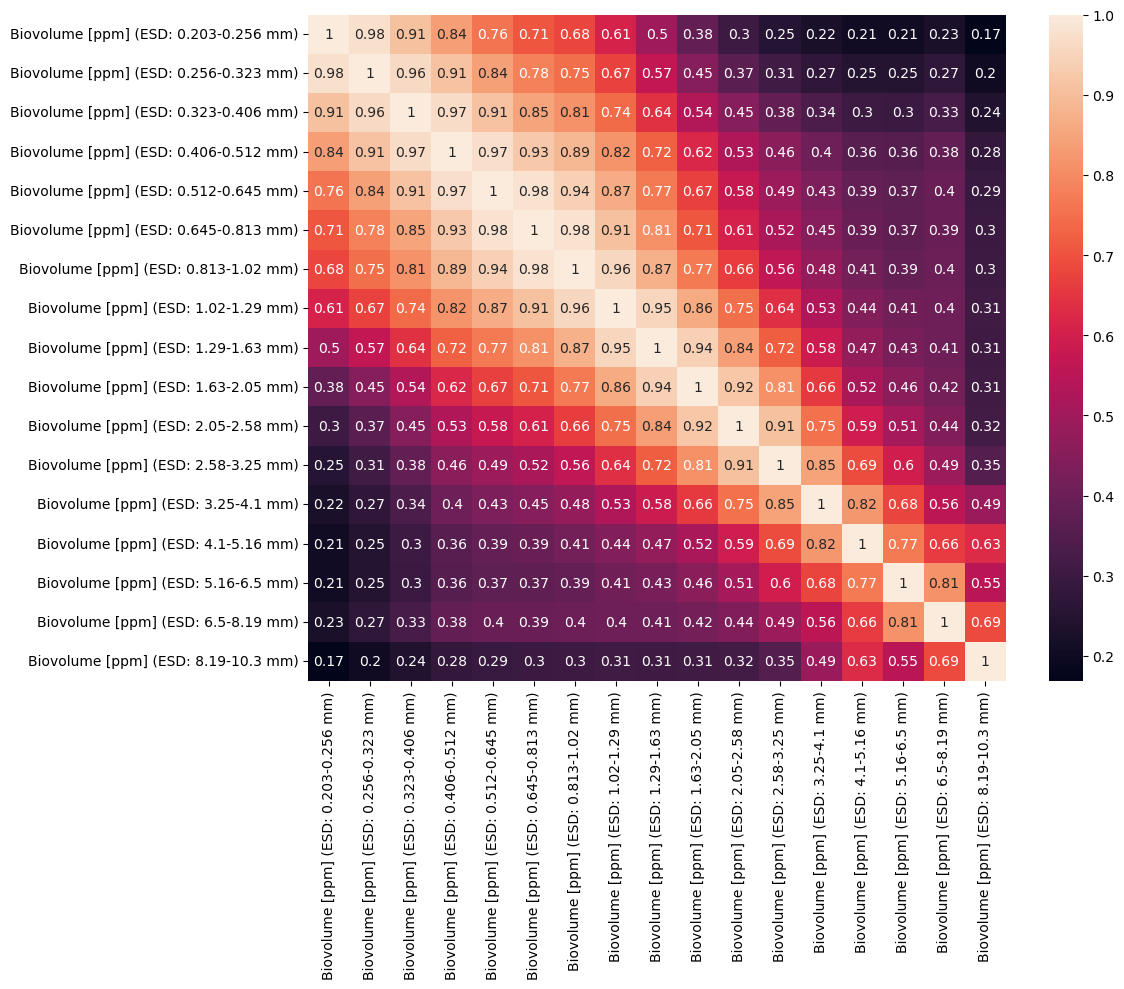

In [8]:
# Example: Plotting a heatmap to show feature correlations
plt.figure(figsize=(12, 10))
df = BV_data #Create a dataframe that only contains numerical values
df = df.drop(columns=['Profile_id', "depth", "depth_bin"]) 
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.tight_layout()
plt.show()
# --> The Biovolume of sizeclasses that are closely related have a high correlation, but the biovolume of very small and very large particle sizes is only poorly correlated
# --> All values are positievly correlated. There is no negative correlation


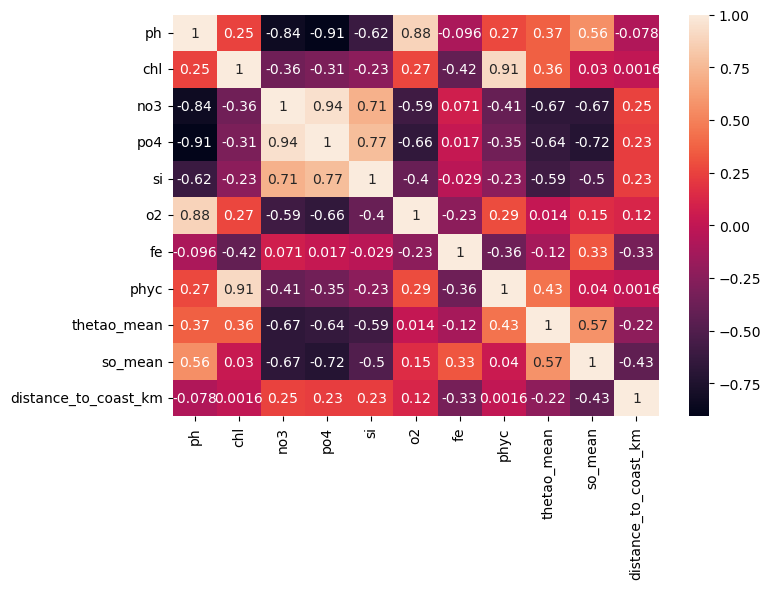

In [9]:
# Example: Plotting a heatmap to show feature correlations
plt.figure(figsize=(8, 6))
df2 = env_data_subset #Create a dataframe that only contains numerical values
df2 = df2.drop(columns=["Profile_id", "Latitude", "Longitude", "datetime", "depth", "MarineRegion"]) 
correlation_matrix = df2.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.tight_layout()
plt.show()
# In the target values there is high correlation (>0.7) between:
# ph & o2; chl & phyc; po4 & no3; si & no3; si & po4
# There is high anticorrelation (<-0.7) between:
# ph & no3; ph & po4; po4 & so_mean; 


In [10]:
# merge datasets due to their profile Id and their depth to see whether there are any correlations between biovolume (feature data) and environmental data (target data)
merged_df = pd.merge(
    BV_data, env_data_subset, 
    on=['Profile_id', 'depth'],  # Schlüsselspalten
    how='left'                   # 'left', 'right', 'inner' oder 'outer'
)
#merged_df.head()
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224520 entries, 0 to 224519
Data columns (total 35 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   Profile_id                             224520 non-null  object        
 1   depth                                  224520 non-null  float64       
 2   depth_bin                              224520 non-null  int64         
 3   Biovolume [ppm] (ESD: 0.203-0.256 mm)  224520 non-null  float64       
 4   Biovolume [ppm] (ESD: 0.256-0.323 mm)  224520 non-null  float64       
 5   Biovolume [ppm] (ESD: 0.323-0.406 mm)  224520 non-null  float64       
 6   Biovolume [ppm] (ESD: 0.406-0.512 mm)  224520 non-null  float64       
 7   Biovolume [ppm] (ESD: 0.512-0.645 mm)  224520 non-null  float64       
 8   Biovolume [ppm] (ESD: 0.645-0.813 mm)  224520 non-null  float64       
 9   Biovolume [ppm] (ESD: 0.813-1.02 mm)   224520 no

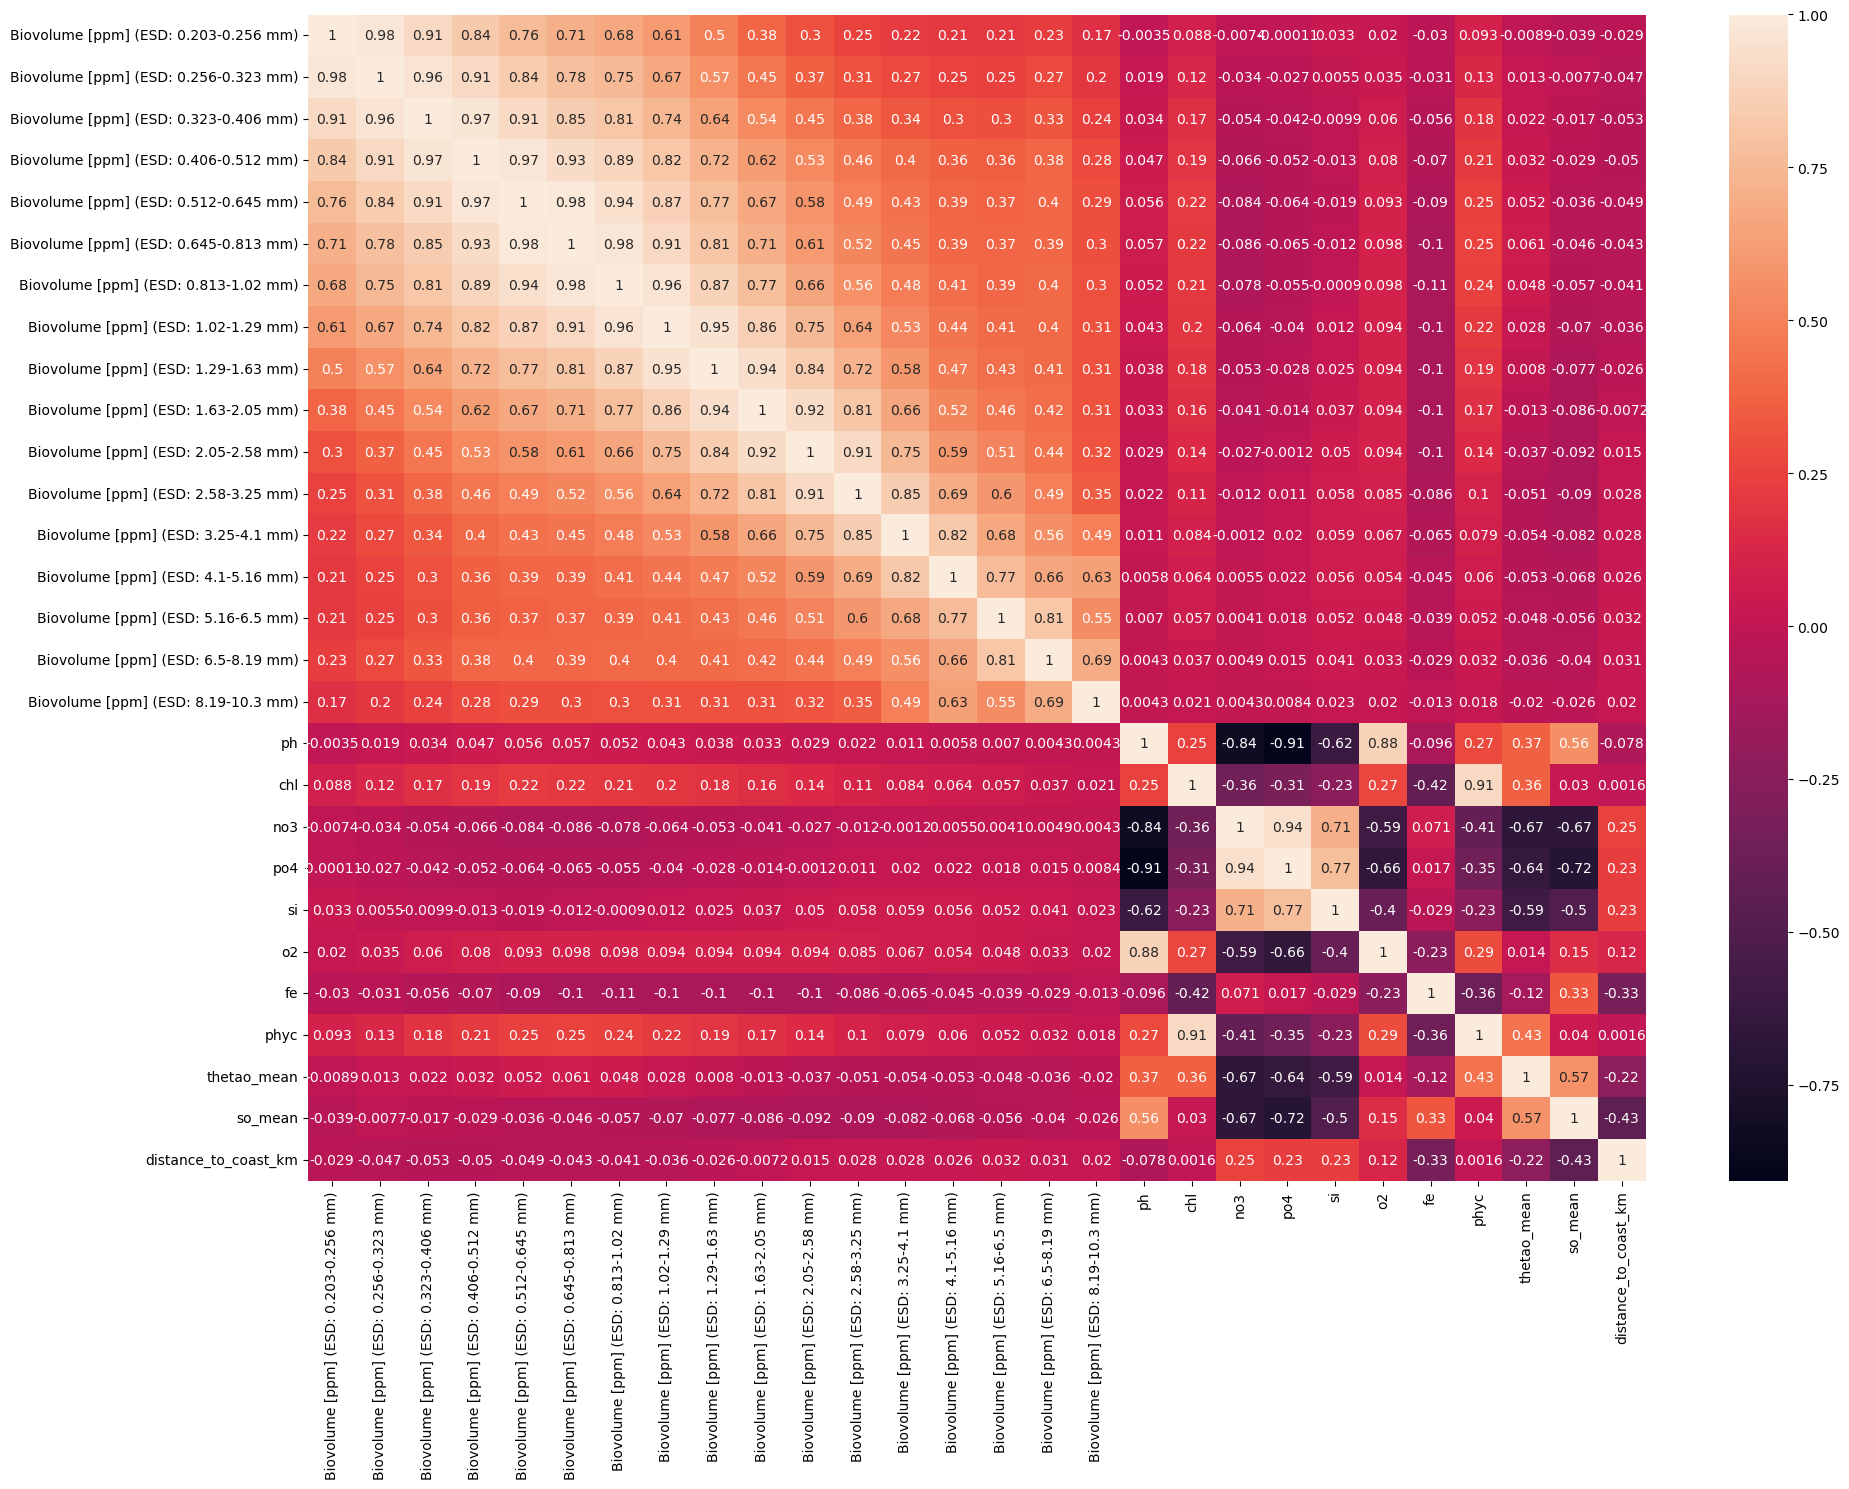

In [11]:
# Example: Plotting a heatmap to show feature correlations
plt.figure(figsize=(20, 15))
merged_df = merged_df.drop(columns=['Profile_id', "depth", "depth_bin", "Latitude", "Longitude", "datetime", "MarineRegion"]) 
correlation_matrix = merged_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.tight_layout()
plt.show()
# --> No real correlation between Biovolume (feature data) and environmental data (target data)


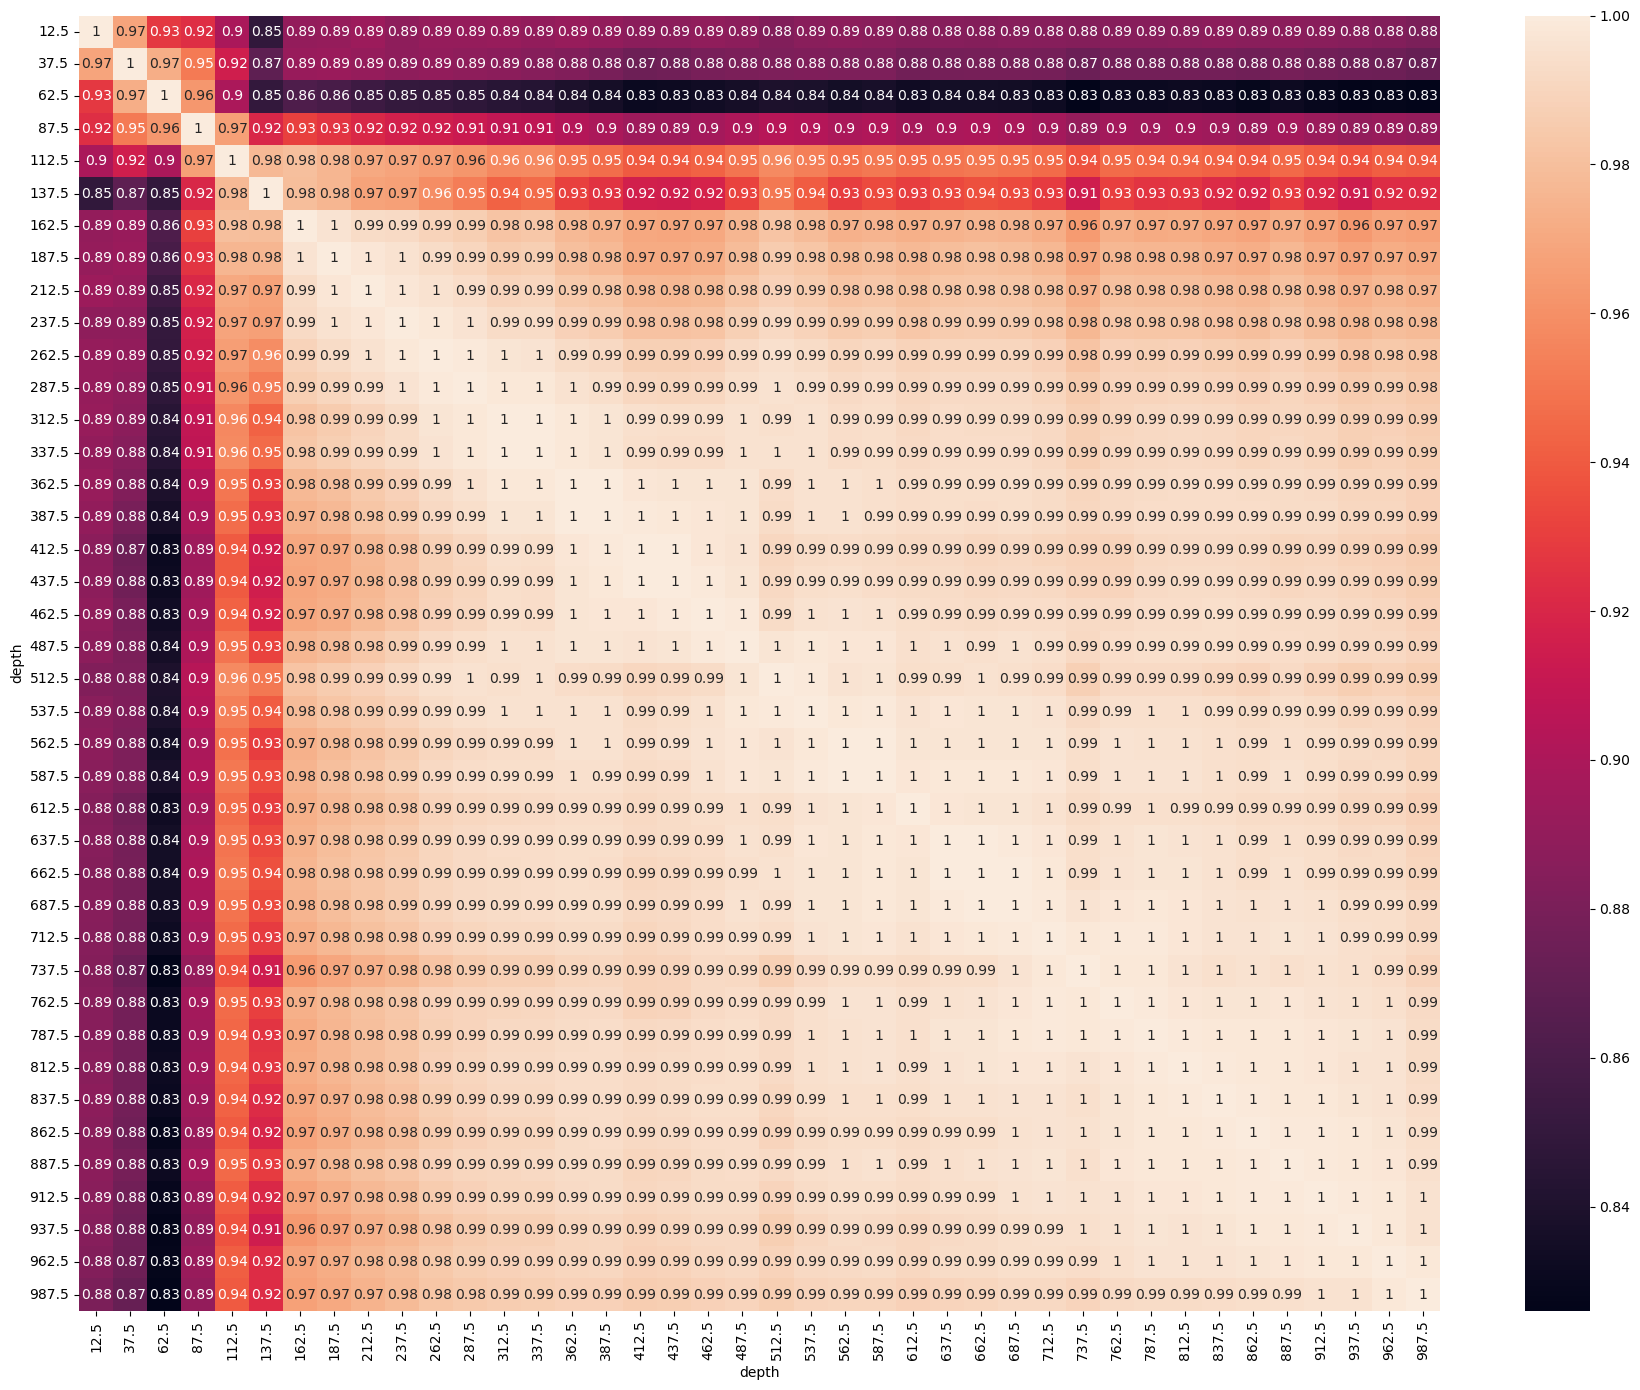

In [ ]:
# Determine how biovolume values in each depth layer correlate with the biovolume data of the other depth layers
biovolume_cols = [col for col in BV_data.columns if 'Biovolume' in col]

plt.figure(figsize=(18, 14))
# Pivotieren: Profile_id bleibt Index, depth wird zu Spalten
df_pivot = BV_data.pivot(index='Profile_id', columns='depth', values=biovolume_cols[0])
corr_depths = df_pivot.corr()  
sns.heatmap(corr_depths, annot=True)
plt.tight_layout()
plt.show()
# --> The results show that there is a very high correlation between depth. Has one biovolume class a high value in 12.5m it also has a high value in 100m, etc. 